<a href="https://colab.research.google.com/github/zelal-Eizaldeen/project2_Walmart_Price_Prediction/blob/main/Assignment_4_3113_zelalae2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Team Members**

Zilal Eiz Aldin (Online MCS) Zelalae2@illinois.edu

Mesay Taye (Online MCS) mesayst2@illinois.edu

Jianci Zhai (Online MCS) jianciz2@illinois.edu

# **Contribution of each member**

XXX By Mesay

XXX By Zilal

XXX By Jianci

# **Reference**
https://campuswire.com/c/GB46E5679/feed/587

https://liangfgithub.github.io/Coding/F24_Coding4.pdf

# **Setting**

In [16]:

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [17]:

# import all libraries
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import scale
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import ElasticNetCV
from sklearn.metrics import mean_squared_error,make_scorer
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingRegressor
import xgboost as xgb

import warnings
warnings.filterwarnings('ignore')

from scipy.stats import multivariate_normal

from matplotlib.colors import LogNorm

from sklearn.model_selection import GridSearchCV
from sklearn.mixture import GaussianMixture

# **Part I: Gaussian Mixtures**

reference:

https://liangfgithub.github.io/PSL/w7/w7_3_EM.html

https://campuswire.com/c/GB46E5679/feed/589 (hint)


In [18]:
#change with your path
path_to_data='/content/drive/MyDrive/MastersDegree/CS598 PSL/Assignments/CA/'

Text(0, 0.5, 'Duration')

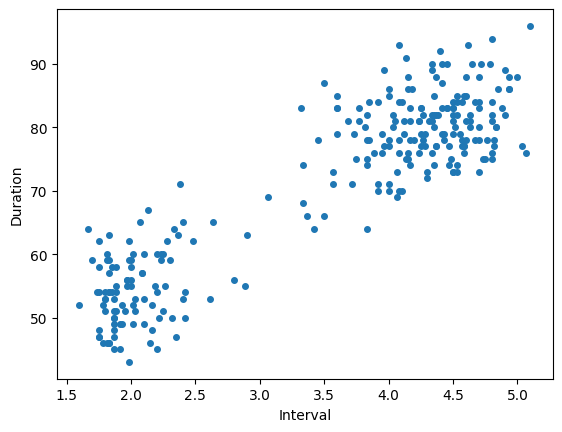

In [19]:
data = pd.read_table(path_to_data+"faithful.dat", sep="\s+", index_col=0)
plt.scatter(data['eruptions'], data['waiting'], 16)
plt.xlabel('Interval')
plt.ylabel('Duration')

In [20]:
data.head()

,eruptions,waiting
1,3.600,79
2,1.800,54
3,3.333,74
4,2.283,62
5,4.533,85


In [337]:
#create a matrix for all sample sizes for G, the corresponding p, u
def create_s_mtrx(G,n,s_interval=10): #sample size interval is default to 10, not required by instruction, but will need to handle G >2 as required by the instruction
  #matrix of G/ aka Z
  G_mtrx = np.arange(1,G+1,1)
  #sample size by group
  s_mtrx = s_interval*2**(G_mtrx-1)

  cumsum_s_mtrx =  np.cumsum(s_mtrx, axis =0)
  cumsum_s_mtrx

  #anything above limit taking 0s
  G_mtrx[cumsum_s_mtrx > n] = 0
  s_mtrx[cumsum_s_mtrx > n] = 0
  cumsum_s_mtrx[cumsum_s_mtrx > n] = 0
  #print(cumsum_s_mtrx)

  #biggest possible matrix
  max_G = np.where(cumsum_s_mtrx>0)[0][-1]+2

  final_G = min(max_G,G)
  last_s_mtrx = n - sum(s_mtrx[0:final_G-1])
  s_mtrx[final_G-1]=last_s_mtrx
  try:
    s_mtrx[final_G:]=0
  except:
    pass

  G_mtrx_final = np.arange(1,final_G+1,1)
  s_mtrx_final = s_mtrx[0:final_G]


  # initialize matrix of p
  p_mtrx = s_mtrx_final /n

  #create a new dim in data to show the G assignment
  G_assignment = np.repeat(G_mtrx_final,s_mtrx_final)

  #data with g assignment
  data_wg = data.copy()
  data_wg['G'] = G_assignment

  # calculate U by group for the two dimenison
  # keep column names so it's easier to understand
  u_by_k = data_wg.groupby('G').mean().transpose()
  #u_by_k.columns = [ 'G','eruptions_avg',	'waiting_avg']

  return   G_mtrx_final, s_mtrx_final, p_mtrx, final_G, data_wg, u_by_k


In [338]:
#number of componants
G=2
#sample size
n=len(data)

G_mtrx, s_mtrx, p_mtrx, final_G,data_wg, u_by_k= create_s_mtrx(G,n,s_interval=10)

In [262]:
G_mtrx

array([1, 2])

In [263]:
s_mtrx

array([ 10, 262])

In [264]:
p_mtrx

array([0.03676471, 0.96323529])

In [276]:
data_wg

,eruptions,waiting,G
1,3.600,79,1
2,1.800,54,1
3,3.333,74,1
4,2.283,62,1
5,4.533,85,1
...,...,...,...
268,4.117,81,2
269,2.150,46,2
270,4.417,90,2
271,1.817,46,2


In [294]:
data_mtrx = data[['eruptions','waiting']].to_numpy().reshape(-1,1)

In [339]:
u_by_k

G,1,2
eruptions,3.3032,3.494828
waiting,71.8000,70.862595


In [342]:
u_by_k_mtx = u_by_k.to_numpy()
u_by_k_mtx

array([[ 3.3032    ,  3.49482824],
       [71.8       , 70.86259542]])

In [345]:
u_by_k_mtx[0]

array([3.3032    , 3.49482824])

In [360]:
data_erp[0:5]

array([[ 0.2968    ,  0.10517176],
       [-1.5032    , -1.69482824],
       [ 0.0298    , -0.16182824],
       [-1.0202    , -1.21182824],
       [ 1.2298    ,  1.03817176]])

In [361]:
data_wait[0:5]

array([[  7.2       ,   8.13740458],
       [-17.8       , -16.86259542],
       [  2.2       ,   3.13740458],
       [ -9.8       ,  -8.86259542],
       [ 13.2       ,  14.13740458]])

In [347]:
data_erp = data_wg_cal['eruptions'].to_numpy().reshape(-1,1) - u_by_k_mtx[0]#average eruptions time
data_wait = data_wg_cal['waiting'].to_numpy().reshape(-1,1) - u_by_k_mtx[1]#average waiting time

In [366]:
np.hstack((data_erp.T[0],data_wait.T[0])).reshape(-1,2)

array([[ 2.9680e-01, -1.5032e+00],
       [ 2.9800e-02, -1.0202e+00],
       [ 1.2298e+00, -4.2020e-01],
       [ 1.3968e+00,  2.9680e-01],
       [-1.3532e+00,  1.0468e+00],
       [-1.4702e+00,  6.1380e-01],
       [ 8.9680e-01, -1.5532e+00],
       [ 1.3968e+00, -1.1362e+00],
       [-1.5532e+00,  1.4968e+00],
       [-1.7032e+00,  9.4680e-01],
       [-1.5032e+00, -1.5532e+00],
       [ 1.4680e-01, -2.3620e-01],
       [ 1.2298e+00,  2.9680e-01],
       [-1.3362e+00,  7.7980e-01],
       [ 5.4680e-01,  1.1298e+00],
       [ 9.9680e-01,  1.1638e+00],
       [ 6.3800e-02,  7.2980e-01],
       [ 5.2980e-01, -1.2862e+00],
       [-1.4362e+00,  1.5298e+00],
       [-1.4702e+00,  1.4798e+00],
       [ 1.0468e+00, -1.4202e+00],
       [ 1.2638e+00, -1.5532e+00],
       [ 1.2298e+00,  1.3800e-02],
       [ 5.2980e-01, -1.2032e+00],
       [ 1.3298e+00, -1.3032e+00],
       [ 1.4968e+00,  1.4128e+00],
       [-1.4702e+00,  1.5298e+00],
       [-1.5702e+00,  1.5798e+00],
       [ 4.1380e-01,

In [362]:
np.hstack((data_erp.T[0,1],data_erp[:,0])).reshape(-1,2)[0:5]

array([[ 0.2968, -1.5032],
       [ 0.0298, -1.0202],
       [ 1.2298, -0.4202],
       [ 1.3968,  0.2968],
       [-1.3532,  1.0468]])

In [350]:
data_erp.T[0]

array([ 0.2968, -1.5032,  0.0298, -1.0202,  1.2298, -0.4202,  1.3968,
        0.2968, -1.3532,  1.0468, -1.4702,  0.6138,  0.8968, -1.5532,
        1.3968, -1.1362, -1.5532,  1.4968, -1.7032,  0.9468, -1.5032,
       -1.5532,  0.1468, -0.2362,  1.2298,  0.2968, -1.3362,  0.7798,
        0.5468,  1.1298,  0.9968,  1.1638,  0.0638,  0.7298,  0.5298,
       -1.2862, -1.4362,  1.5298, -1.4702,  1.4798,  1.0468, -1.4202,
        1.2638, -1.5532,  1.2298,  0.0138,  0.5298, -1.2032,  1.3298,
       -1.3032,  1.4968,  1.4128, -1.4702,  1.5298, -1.5702,  1.5798,
        0.4138, -1.6362,  1.2638,  1.0138, -1.0702,  1.1968, -1.5532,
        1.4968, -1.4862,  1.0968,  0.8638,  1.3968, -1.2362,  1.3968,
        0.7298, -1.3362,  1.1968,  0.6968, -1.3202,  1.7638, -1.2862,
        1.2638,  0.5798,  0.2968,  0.8298,  1.0298,  0.7968, -0.6702,
        0.7638,  1.6298,  0.6468,  1.2138, -1.1362,  0.6968, -1.1032,
        1.0298, -1.4362,  1.5138, -1.4702,  0.9968,  1.3638,  0.4468,
       -1.4362,  1.5

In [283]:
#can be simplified - need to rewrite
data_wg_cal['eruptions_diff'] = data_wg_cal['eruptions'] - data_wg_cal['eruptions_avg']
data_wg_cal['waiting_diff'] = data_wg_cal['waiting'] - data_wg_cal['waiting_avg']

In [284]:
data_wg_cal

,eruptions,waiting,G,eruptions_avg,waiting_avg,eruptions_diff,waiting_diff
0,3.600,79,1,3.303200,71.800000,0.296800,7.200000
1,1.800,54,1,3.303200,71.800000,-1.503200,-17.800000
2,3.333,74,1,3.303200,71.800000,0.029800,2.200000
3,2.283,62,1,3.303200,71.800000,-1.020200,-9.800000
4,4.533,85,1,3.303200,71.800000,1.229800,13.200000
...,...,...,...,...,...,...,...
267,4.117,81,2,3.494828,70.862595,0.622172,10.137405
268,2.150,46,2,3.494828,70.862595,-1.344828,-24.862595
269,4.417,90,2,3.494828,70.862595,0.922172,19.137405
270,1.817,46,2,3.494828,70.862595,-1.677828,-24.862595


In [323]:
# [a,b] * [a,b].T is bascially a^2 + b^2
data_wg_cal['sigma'] = data_wg_cal['eruptions_diff']**2 + data_wg_cal['waiting_diff']**2

In [325]:
data_wg_cal.groupby('G')['sigma'].sum()

,sigma
G,
1,1979.644454
2,48451.694646


In [316]:
data_diff_mtrx[1]

array([ -1.5032, -17.8   ])

In [319]:
17.8**2

316.84000000000003

In [312]:
data_diff_mtrx[1]*data_diff_mtrx[1].T

array([  2.25961024, 316.84      ])

In [308]:
for vector in data_diff_mtrx:
    vector = vector.reshape(2, 1)  # Reshape to 2x1 column vector
    result = np.dot(vector, vector.T)

In [309]:
result

array([[0.94511792, 3.05009612],
       [3.05009612, 9.8433075 ]])

In [299]:
data_diff_mtrx.T

array([[ 2.96800000e-01, -1.50320000e+00,  2.98000000e-02,
        -1.02020000e+00,  1.22980000e+00, -4.20200000e-01,
         1.39680000e+00,  2.96800000e-01, -1.35320000e+00,
         1.04680000e+00, -1.66182824e+00,  4.22171756e-01,
         7.05171756e-01, -1.74482824e+00,  1.20517176e+00,
        -1.32782824e+00, -1.74482824e+00,  1.30517176e+00,
        -1.89482824e+00,  7.55171756e-01, -1.69482824e+00,
        -1.74482824e+00, -4.48282443e-02, -4.27828244e-01,
         1.03817176e+00,  1.05171756e-01, -1.52782824e+00,
         5.88171756e-01,  3.55171756e-01,  9.38171756e-01,
         8.05171756e-01,  9.72171756e-01, -1.27828244e-01,
         5.38171756e-01,  3.38171756e-01, -1.47782824e+00,
        -1.62782824e+00,  1.33817176e+00, -1.66182824e+00,
         1.28817176e+00,  8.55171756e-01, -1.61182824e+00,
         1.07217176e+00, -1.74482824e+00,  1.03817176e+00,
        -1.77828244e-01,  3.38171756e-01, -1.39482824e+00,
         1.13817176e+00, -1.49482824e+00,  1.30517176e+0

In [300]:
data_diff_mtrx[]

array([[ 2.96800000e-01,  7.20000000e+00],
       [-1.50320000e+00, -1.78000000e+01],
       [ 2.98000000e-02,  2.20000000e+00],
       [-1.02020000e+00, -9.80000000e+00],
       [ 1.22980000e+00,  1.32000000e+01],
       [-4.20200000e-01, -1.68000000e+01],
       [ 1.39680000e+00,  1.62000000e+01],
       [ 2.96800000e-01,  1.32000000e+01],
       [-1.35320000e+00, -2.08000000e+01],
       [ 1.04680000e+00,  1.32000000e+01],
       [-1.66182824e+00, -1.68625954e+01],
       [ 4.22171756e-01,  1.31374046e+01],
       [ 7.05171756e-01,  7.13740458e+00],
       [-1.74482824e+00, -2.38625954e+01],
       [ 1.20517176e+00,  1.21374046e+01],
       [-1.32782824e+00, -1.88625954e+01],
       [-1.74482824e+00, -8.86259542e+00],
       [ 1.30517176e+00,  1.31374046e+01],
       [-1.89482824e+00, -1.88625954e+01],
       [ 7.55171756e-01,  8.13740458e+00],
       [-1.69482824e+00, -1.98625954e+01],
       [-1.74482824e+00, -2.38625954e+01],
       [-4.48282443e-02,  7.13740458e+00],
       [-4.

In [313]:
A = np.array([1,2])
A.T

array([1, 2])

In [314]:
np.dot(A , A.T)

5

In [33]:
#initialize p1:pn
#for the G = 2 case, start with assuming 10 samples from G1, which will
#result in p1-hat = 10/n

p1 = s_interval/n
p1

0.03676470588235294

In [24]:
p2 = 1-p1
p2

0.9632352941176471

In [29]:
u1 = np.mean(data,axis = 0)
u1

,0
eruptions,3.487783
waiting,70.897059


In [27]:
#initialize a matrix for p with 0s, output required for E-step
p_mtrx = np.zeros((n,G))
p_mtrx.shape

(272, 2)

Estep function: This function should return an n-by-G matrix, where the (i, j)th entry represents the
conditional probability P(Zi = k | xi). Here i ranges from 1 to n and k ranges from 1 to G.


Mstep function: This function should return the updated parameters for the Gaussian mixture model.


loglik function: This function computes the log-likelihood of the data given the parameters.

myEM function (main function): Inside this function, you can call the Estep and Mstep functions. The
function should take the following inputs and return the estimated parameters and log-likelihood (via
the loglik function)

# **Part II: HMM**

Baum-Welch Algorihtm

Viterbi Algorihtm